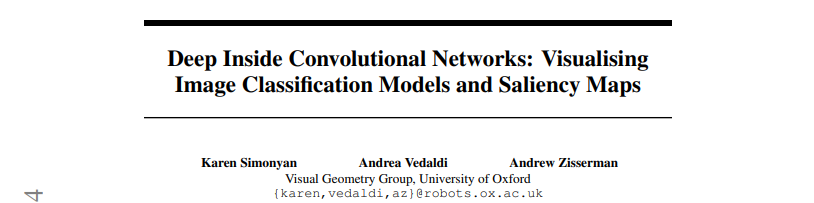

CAM에서는 CNN 구조의 top에 GAP layer를 두고, Dense layer를 쌓아서 이의 가중치와 마지막 Conv layer의 feature 맵을 곱하여 모델이 어떤 부분을 보고 클래스를 분류하는지 알아봤습니다.

**Saliency Map**도 마찬가지로 이미지에서 어떤 부분을 집중하는지 살펴보는 방법입니다.

이 방법은 다른 영역에 비해서 **픽셀값의 변화가 급격한 부분**을 모아서 매핑한 후에 관심있는 물체를 관심이 없는 배경과 분리시키는 방법론입니다.

즉, 모델이 분류를 할 때 중요하게 생각하는 부분의 픽셀을 강조하여 보여줄 수 있습니다.

# Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

# Download and prepare the dataset


In [2]:
# Cats vs Dogs Dataset
tfds.disable_progress_bar()
 
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
 
# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
 
(train_examples, validation_examples, test_examples) = splits
 
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
 
BATCH_SIZE = 32
 
def normalize_and_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (224, 224))
 
    return image, label
 
# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(normalize_and_resize).batch(1)

train/valid/test dataset을 준비합니다

# Modeling and Train

In [3]:
def build_model():
    base_model = tf.keras.applications.VGG16(input_shape= (224, 224, 3),
                                             weights='imagenet',  # 사전 훈련된 가중치
                                             include_top=False)  # FC layer는 포함하지 않겠다. 특징 추출기만 가져온다.
    
    # basemodel의 출력을 입력으로 받아 GAP 레이어 추가
    output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)  
 
    # output 레이어에 2개의 뉴런을 가진 Dense 레이어 추가. 개, 고양이에 대한 확률을 나타냄
    output = tf.keras.layers.Dense(2, activation='softmax')(output)
 
    # 모델 (input,output) 생성
    model = tf.keras.Model(base_model.input, output)
 
    for layer in base_model.layers[:-4]:  # 마지막 4개 레이어를 제외한 모든 레이어를 동결시킴
        layer.trainable = False           # 사전 훈련된 가중치를 고정시켜 업데이트되지 않도록함
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    model.summary()
 
    return model
    
model = build_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

top의 classifier을 제외한 VGG16 모델을 불러오고, classifier는 GAP와 Dense layer로 구성

10 Epochs 학습을 진행

In [4]:
EPOCHS = 10
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 62s 100ms/step - loss: 1.5232 - acc: 0.7169 - val_loss: 0.2078 - val_acc: 0.9093
Epoch 2/10
582/582 [==============================] - 57s 97ms/step - loss: 0.2175 - acc: 0.9234 - val_loss: 0.2488 - val_acc: 0.9261
Epoch 3/10
582/582 [==============================] - 57s 97ms/step - loss: 0.1860 - acc: 0.9474 - val_loss: 0.1592 - val_acc: 0.9347
Epoch 4/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1270 - acc: 0.9577 - val_loss: 0.1586 - val_acc: 0.9321
Epoch 5/10
582/582 [==============================] - 57s 97ms/step - loss: 0.1162 - acc: 0.9632 - val_loss: 0.1495 - val_acc: 0.9394
Epoch 6/10
582/582 [==============================] - 57s 97ms/step - loss: 0.0986 - acc: 0.9693 - val_loss: 0.1216 - val_acc: 0.9540
Epoch 7/10
582/582 [==============================] - 57s 97ms/step - loss: 0.0937 - acc: 0.9740 - val_loss: 0.1569 - val_acc: 0.9566
Epoch 8/10
582/582 [==============================] - 56s 96m

위에는 개고양이 데이터를 imagenet의 가중치와 VGG16 구조를 통해 10 에포크만큼 학습한 결과입니다

.

확인해볼 이미지를 랜덤하게 추출하고, 실제 label 값을 one-hot으로 나타냅니다.

In [5]:
test_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [6]:
image, label = iter(test_batches.shuffle(1024)).__next__()
print(label)
 
class_index = label
num_classes = 2
 
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

tf.Tensor([1], shape=(1,), dtype=int64)


In [7]:
expected_output

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0., 1.]]], dtype=float32)>

모델을 통해 예측값을 얻고, loss를 구한 후에 Gradient Descent를 통해서 입력에 대한 미분값을 구합니다.

In [8]:
with tf.GradientTape() as tape:
    inputs = tf.cast(image, tf.float32)   # 이미지를 부동소수점 형태로 변환하여 입력으로 할당
    tape.watch(inputs)
    predictions = model(inputs)
    
    loss = tf.keras.losses.categorical_crossentropy(expected_output[0], predictions)
 
gradients = tape.gradient(loss, inputs)

In [9]:
gradients

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ 2.09178770e-21,  1.08105155e-20,  2.73540833e-21],
         [-4.48975703e-21,  7.77066877e-21, -7.10740401e-21],
         [-1.06580235e-20, -4.62243208e-22, -1.86553317e-20],
         ...,
         [ 4.18223164e-20,  5.39455885e-20,  3.49706114e-20],
         [ 3.15609923e-20,  4.02060669e-20,  2.49786218e-20],
         [ 1.56321190e-20,  1.86931186e-20,  1.16826805e-20]],

        [[ 7.01771792e-21,  2.16190649e-20,  5.36508134e-21],
         [ 5.01069341e-21,  2.61199242e-20, -4.43622698e-21],
         [ 4.15777205e-21,  2.35923187e-20, -1.51663097e-20],
         ...,
         [ 3.21858400e-20,  3.48043642e-20,  9.65291583e-21],
         [ 1.48829599e-20,  9.59721685e-21, -8.37920147e-21],
         [ 7.39976954e-21,  2.11363226e-21, -5.80489424e-21]],

        [[ 1.11290237e-20,  2.51615579e-20,  3.20876183e-21],
         [ 1.31040256e-20,  3.00553135e-20, -1.14100639e-20],
         [ 1.03031905e-20,  2.15414957e-20

In [10]:
# 결과값을 더 잘 보기위해 RGB를 회색조로 변환
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)
 
# 픽셀 값을 [0, 255] 범위로 정규화합니다.

normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)
 
# 채널 차원을 제거하여 텐서를 2d 텐서로 만듭니다.
normalized_tensor = tf.squeeze(normalized_tensor)
print(normalized_tensor.shape)

(224, 224)


normalized_tensor가 어떤 픽셀들에게 집중하는지 먼저 살펴보고, 원본 이미지와 비교해보겠습니다.

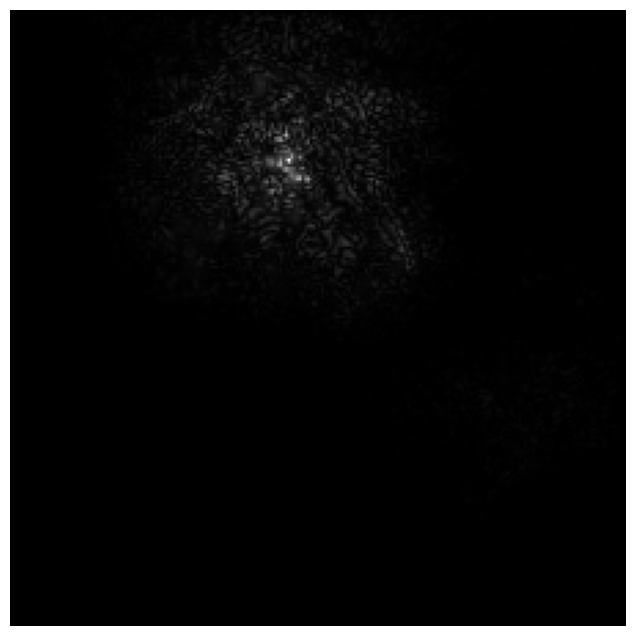

In [11]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

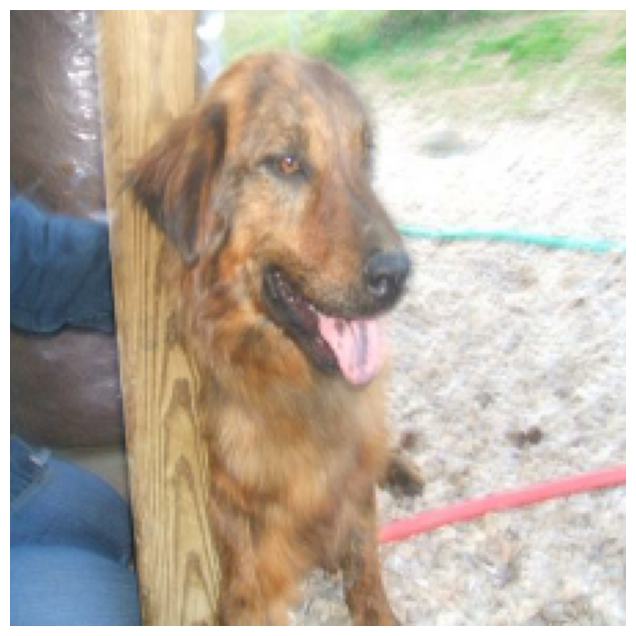

In [12]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(image[0], cmap='gray')
plt.show()

강아지의 얼굴을 주로 보고 분류를 한 것을 알 수 있다.